#### Lesson 5. Subtract One Raster from Another and Export a New Geotiff in Python

**In This Lesson**
Learning Objectives
- What You Need
- Canopy Height Model
- Export a Raster
- Optional Challenge

**Learning Objectives**

After completing this tutorial, you will be able to:
- Derive a CHM in Python using raster math.

**Be sure to set your working directory**

`os.chdir("path-to-you-dir-here/earth-analytics/data")`

In [1]:
# import necessary python packages
import rasterio as rio
from rasterio.plot import plotting_extent
import numpy as np
import earthpy as et
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import earthpy.spatial as es
import os
import seaborn as sns
plt.ion()

# set plot parameters (optional)
plt.rcParams['figure.figsize'] = (8, 8)

# prettier plotting with seaborn
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")

# set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [25]:
# open raster data
with rio.open('data/colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif') as lidar_dem:
    lidar_dem_im = lidar_dem.read(1, masked = True)
    
    #get bounds for plotting
    bounds = plotting_extent(lidar_dem)

#### Import Digital Surface Model (DSM)

Next, you will open the digital surface model (DSM). The DSM represents the top of the earth’s surface. Thus, it includes trees, buildings and other objects that sit on the earth.

In [9]:
# open digital surface model
with rio.open('data/colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DSM.tif') as lidar_dsm:
    lidar_dsm_im = lidar_dsm.read(1, masked = True)
    
lidar_dsm_im

masked_array(
  data=[[--, --, --, ..., 1695.6300048828125, 1695.5899658203125,
         1696.3900146484375],
        [--, --, --, ..., 1695.5999755859375, 1695.6300048828125, 1697.0],
        [--, --, --, ..., 1695.3800048828125, 1695.43994140625,
         1695.449951171875],
        ...,
        [--, --, --, ..., 1681.449951171875, 1681.3900146484375, 1681.25],
        [--, --, --, ..., 1681.719970703125, 1681.5699462890625,
         1681.5599365234375],
        [--, --, --, ..., 1681.8900146484375, 1681.8099365234375,
         1681.739990234375]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-3.402823e+38,
  dtype=float32)

#### Canopy Height Model

The canopy height model (CHM) represents the HEIGHT of the trees. This is not an elevation value, rather it’s the height or distance between the ground and the top of the trees (or buildings or whatever object that the lidar system detected and recorded).

Some canopy height models also include buildings, so you need to look closely at your data to make sure it was properly cleaned before assuming it represents all trees!

**Calculate difference between two rasters**

There are different ways to calculate a CHM. One easy way is to subtract the DTM from the DSM.

**DSM - DSM = CHM**

This math gives you the residual value or difference between the top of the earth surface and the ground which should be the heights of the trees (and buildings if the data haven’t been “cleaned”).

***
Data Tip: Note that this method of subtracting 2 rasters to create a CHM may not give you the most accurate results! There are better ways to create CHM’s using the point clouds themselves. However, in this lesson you learn this method as a means to get more familiar with the CHM dataset and to understand how to perform raster calculations in Python.
***

Before you subtract the two rasters, be sure to check to see if they cover the same area.

In [26]:
# are the bounds the same?
print("Is the spatial extent the same?", lidar_dem.bounds == lidar_dsm.bounds),

# is the resolution the same?
print("Is the resolution the same?", lidar_dem.res == lidar_dsm.res)

Is the spatial extent the same? True
Is the resolution the same? True


It looks like the bounds and resolution are the same. This means it is safe for you to subtract the two rasters without significant errors or uncertainty introduced.

In [27]:
# calculate canopy height model
lidar_chm_im = lidar_dsm_im - lidar_dem_im 

Finally, plot your newly created canopy height model.

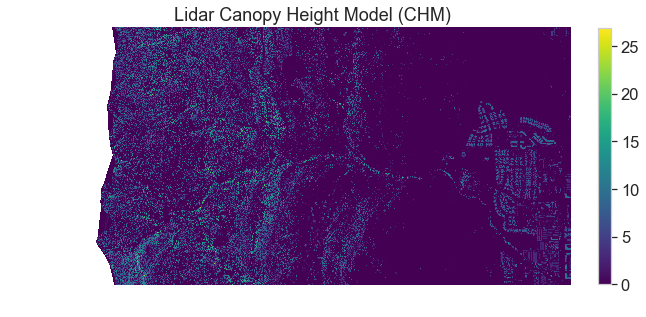

In [28]:
# plot the data
fig, ax = plt.subplots(figsize = (10, 6))
chm_plot = ax.imshow(lidar_chm_im,
                    cmap = 'viridis')
fig.colorbar(chm_plot, fraction = .023, ax = ax)
ax.set_title("Lidar Canopy Height Model (CHM)")
ax.set_axis_off();

A plot of a Lidar derived canopy height model for Lee Hill Road in Boulder, CO.

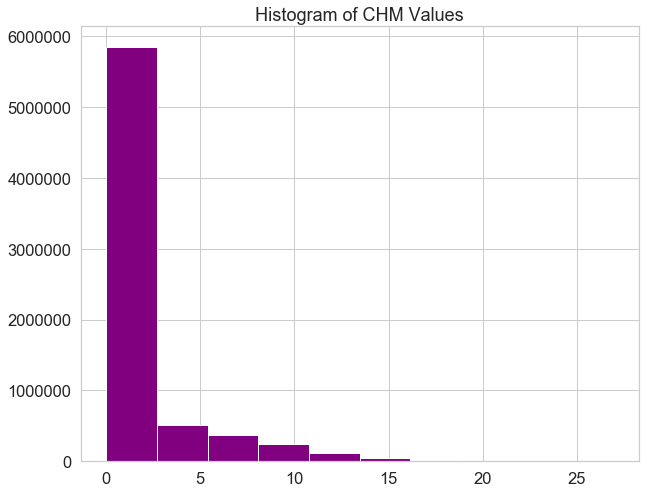

In [29]:
# plot histogram of Canopy Height Model (CHM) values
fig, ax = plt.subplots(figsize = (10, 8))
ax.hist(lidar_chm_im.ravel(), 
       color = 'purple')
ax.set_title("Histogram of CHM Values");

A histogram of a Lidar derived canopy height model values for Lee Hill Road in Boulder, CO.

Take a close look at the CHM plot. Do you think that the data just represents trees? Or do you see anything that may suggest that there are other types of objects represented in the data?

#### Explore the CHM Data

Next, explore the data values in your CHM. Think about the values representing things like trees and buildings in your data.

Do the data make sense?

In [30]:
# print min and max height values of CHM
print('CHM minimum value: ', lidar_chm_im.min())
print('CHM maximum value: ', lidar_chm_im.max())

CHM minimum value:  0.0
CHM maximum value:  26.930054


#### Export a Raster

You can export a raster file in python using the rasterio write() function. Export the canopy height model that you just created to your data folder. You will create a new directory called “outputs” within the colorado-flood directory. This structure allows you to keep things organized, separating your outputs from the data you downloaded.

NOTE: you can use the code below to check for and create an outputs directory. OR, you can create the directory yourself using the finder (MAC) or windows explorer.

In [31]:
# if/else statement to create new folder if it doesn't exist
if os.path.exists('data/colorado-flood/spatial/outputs'):
    print('The directory exists!')
else:
    os.makedirs('data/colorado-flood/spatial/outputs')

The directory exists!


#### Exporting Numpy Arrays to Geotiffs

Next, you need to consider the metdata associated with your chm. Remember that the chm was generated using 2 numpy arrays. Neither of these arrays has spatial data directly associated with it. BUT you do have the rasterio object that has metadata that you can use if you want to assign all of the spatial attributes that are needed to save a usable geotiff file.

You can use the syntax

`**dictionary-metadata-object-here`

to apply all of the spatial attributes from one of your raster objects, when you write out your new chm raster.

To begin, have a look at the lidar_dem metadata dictionary. Looking at the example below, all of the metadata in that dictionary are the same as what we expect the output chm to have. Thus we can use the metadata as they are.

In [32]:
lidar_dem.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32613'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 2000,
 'nodata': -3.4028234663852886e+38,
 'transform': Affine(1.0, 0.0, 472000.0,
       0.0, -1.0, 4436000.0),
 'width': 4000}

Next, update the nodata value. The number being used currently is difficult to remember. A more standard value like -999.99 could be a better option. To implement this we will do two things

1. You will assign all masked pixels values which represent nodata values to -999.99 using the np.ma.filled() function.
2. Then you will create a new metadata dictionary that contained the updated nodata value.

In [33]:
lidar_chm_im.min()
lidar_chm_im

masked_array(
  data=[[--, --, --, ..., 0.0, 0.1700439453125, 0.9600830078125],
        [--, --, --, ..., 0.0, 0.090087890625, 1.6400146484375],
        [--, --, --, ..., 0.0, 0.0, 0.0799560546875],
        ...,
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-3.402823e+38,
  dtype=float32)

In [34]:
# fill the masked pixels with a set no data value
nodatavalue = -999.0
lidar_chm_im_fi = np.ma.filled(lidar_chm_im, fill_value = nodatavalue)
lidar_chm_im_fi.min(), nodatavalue

(-999.0, -999.0)

Then update the metadata dictionary.

In [38]:
# update the metadata to ensure the nodata value is properly documented

# create dictionary copy
chm_meta = lidar_dem.meta.copy()
# update the nodata value to be easier to use number
chm_meta.update({'nodata': nodatavalue})
chm_meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32613'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 2000,
 'nodata': -999.0,
 'transform': Affine(1.0, 0.0, 472000.0,
       0.0, -1.0, 4436000.0),
 'width': 4000}

If you want, you can check things like the shape of the numpy array to ensure that it is the same as the width and height of the dem. It should be!

In [39]:
# note the width and height of the dem above. Is the numpy array shape the same
lidar_chm_im_fi.shape

(2000, 4000)

Finally, you can export your raster layer. Below you do the following

1. you use the same rio.open() syntax that you are used to using except now you specify that you are writing a new file with the ‘w’ argument.
2. you specify the new file name and destination in the rio.open() function eg: 'data/colorado-flood/spatial/outputs/lidar_chm.tiff'
3. you specify the metadata as an “unpacked” dictionary using **lidar_dem.meta - doing this allows you to NOT have to specify EACH and EVERY metadata element individually in your output statement - which would be tedious!
4. finally you write the file. output_file.write(your-object-name, layer) Notice that when you make this call you specify both the object name and the layer that you wish to write to a new file. Also notice the outf is the name of the rasterio object as defined below.

In [40]:
# specify new file name and destination
out_path = "data/colorado-flood/spatial/outputs/lidar_chm.tiff"

# write the file
with rio.open(out_path, 'w', **chm_meta) as outf:
    outf.write(lidar_chm_im_fi, 1)

### Optional Challenge

Practice your skills. Open the lidar_chm geotiff file that you just created. Do the following:

1. View the crs - is it correct?
2. View the x and y spatial resolution.
3. Plot the data using a color bar of your choice.

Your plot should look like the one below (athough the colors may be different.

In [41]:
# open newly created lidar_chm geotiff file
with rio.open('data/colorado-flood/spatial/outputs/lidar_chm.tiff') as lidar_chm:
    lidar_chm_im = lidar_chm.read(1, masked=True)
    # get bounds for plotting
    bounds = plotting_extent(lidar_chm)

In [42]:
# view crs
lidar_chm.crs

CRS({'init': 'epsg:32613'})

In [45]:
# view resolution
lidar_chm.res

(1.0, 1.0)

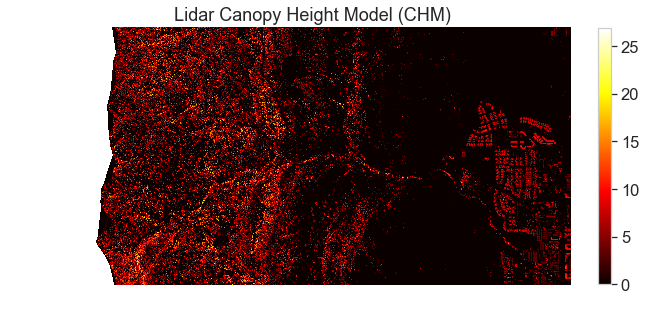

In [53]:
# plot the data
fig, ax = plt.subplots(figsize = (10, 6))
chm_plot = ax.imshow(lidar_chm_im,
                    cmap = 'hot')
fig.colorbar(chm_plot, fraction = .023, ax = ax)
ax.set_title("Lidar Canopy Height Model (CHM)")
ax.set_axis_off();

Lidar canopy height model derived from the DTM and DSM.

***
**Data Tip:** You can simplify the directory code above by using the exclamation not which tells Python to return the INVERSE or opposite of the function you have requested Python to run.
***